In [52]:
import pandas as pd
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import functional as TF
from torchvision import transforms as T
import torch
import albumentations as A

In [55]:
val_df = pd.read_csv('../data/test.csv')
val_df = val_df[~val_df['invalid']]

In [64]:
# define augmentation transforms
transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Rotate(45),
        A.ElasticTransform(
            p=0.4, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03
        ),
    ]
)

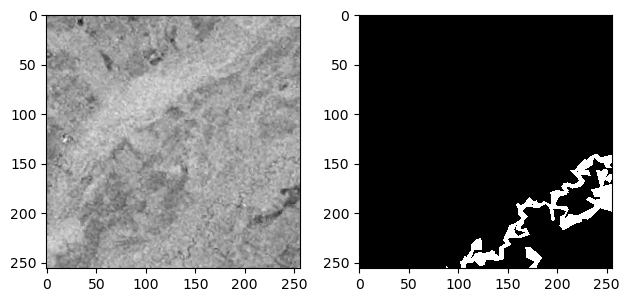

In [59]:
idx = np.random.randint(val_df.shape[0])
img = imread(val_df.loc[idx]['vv_image_path'], as_gray=True)
mask = imread(val_df.loc[idx]['flood_label_path'], as_gray=True)

img = np.stack((img, img, img), axis=2)
_, ax = plt.subplots(1,2)
imshow(img, ax=ax[0])
imshow(mask, ax=ax[1], cmap='gray')

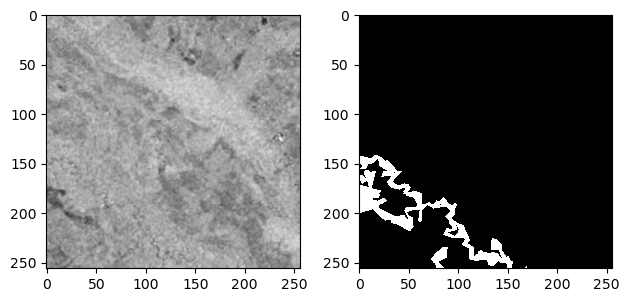

In [73]:
augmented = transform(image=img, mask=mask)

_, ax = plt.subplots(1,2)
imshow(augmented['image'], ax=ax[0])
imshow(augmented['mask'], ax=ax[1], cmap='gray')

In [51]:
mask_t = torch.from_numpy(augmented['mask'])
mask_t.shape

torch.Size([256, 256])